<a href="https://colab.research.google.com/github/sayan0506/Real-Time-Face-Recognition-Using-Siamese-Network-with-Triplet-Loss-in-Keras/blob/master/Copy_of_Face_Recognizer_using_imagenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mounting Google drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Adding Face-Recognition-Master path to the system path
Adding Face-Recognition-Master path to the system path, for accessing necessary modules, else we can't access the cutom modules.

In [ ]:
import sys 

In [ ]:
sys.path.append('/content/gdrive/MyDrive/Face-Recognition-master')

Changing current working directory to /content/gdrive/MyDrive/Face-Recognition-master, if we wouldn't change that, the methods couldn't access the data files stored in the **Face-Recognition-Master** folder

In [ ]:
print('Current working directory becomes')
%cd /content/gdrive/MyDrive/Face-Recognition-master

Current working directory becomes
/content/gdrive/MyDrive/Face-Recognition-master


# Importing Modules

In [ ]:
from keras import backend as K
import time
from multiprocessing.dummy import Pool
K.set_image_data_format('channels_first')
import cv2
import os
import glob
import numpy as np
from matplotlib import pyplot as plt
from numpy import genfromtxt
import tensorflow as tf
from fr_utils import *
from inception_network import *
# from face_functions import *
from keras.models import load_model
from keras.utils.vis_utils import plot_model
# to obtain the encoding of the extracted faces
from fr_utils import img_to_encoding

# modules for accessing local webcam in collab
import capture_photo

# for  extracting faces from images
import face_data_generator

# Defining the Triplet loss function

Triplet loss is used as cost function while compiling the Siamese network

In [13]:
def triplet_loss_function(y_true,y_pred,alpha = 0.3):
	# reference image encoding
	anchor = y_pred[0]
	# positive encoding
	positive = y_pred[1]
	# negative encoding
	negative = y_pred[2]
	# calculating positive and negtive distances
	pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, positive)), axis=-1)
	neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, negative)), axis=-1)
	basic_loss = tf.add(tf.subtract(pos_dist, neg_dist), alpha)
	# triplet loss
	loss = tf.reduce_sum(tf.maximum(basic_loss, 0.0))
	return loss

# Compiling the model

In [14]:
# model object is instantiated with input layer shape
# nh = nw = 96, nc = 3
model = model(input_shape = (3,96,96))
# compiling the model, with 'Adam' optimizer, and loss = triplet
model.compile(optimizer = 'adam', loss = triplet_loss_function, metrics = ['accuracy'])

# Transfer Learning


* Loading weights from trained **Facenet model**

  Here, we are loading the weights of trained **Facenet model**, which is referenced and stored in 'weights' folder in the path '/content/gdrive/MyDrive/Face-Recognition-master'. So, we changed the current working directory 

* Loading the weights

  The weights of the pretrained model is stored in the weights folder of current loation. The weights are being loaded in the network architecture.

In [15]:
load_weights_from_FaceNet(model)

In [ ]:
print('Weights are loaded successfully')

Weights are loaded successfully


In [ ]:
print('Model summary')
#model.summary()
#plot_model(model)

Model summary


In [ ]:
print("Total Parameters of the model:", model.count_params())

Total Parameters of the model: 3743280


# Add facial images to the Database

1. Connecting collab environment with the local webcam.
2. A JS code is used to capture images of each person, when person is present infront of webcam, by pressing the capture button image is stored.
3. If a single face is detected in the image, then it's the valid entry
4. After capturing each image the face is cropped by **frontal_face_detector**, then using **68 facial landmark detction** of that face, and face_utils, dlib library face is aligned.
4. 10 sample faces of each person will be stored in the **facial_images** folder, with each of person_name.



In [ ]:
# Adding faces of person to database
''' 
def add_faces(person):
  # path of images
  path = 'Facial_images'
  # checking whether any folder with that person exista or not
  directory = os.path.join(path, person)
  if not os.path.exists(directory):
    os.makedirs(directory, exist_ok = True)
    print('no')
  # max 10 samples of each person is stored
  MAX_NUMBER_IMAGES = 2
  # counts number of images captured
  count = 0
  while count < MAX_NUMBER_IMAGES:
    filename = person+'.jpg'
    capture_photo.take_photo(filename)
    plt.imshow(plt.imread(filename))
    f_align = face_extraction.face_extraction(img)
    cv2.imwrite(os.path.join(directory, str(person + str(count))+'.jpg'), f_align)
    count = count + 1
    print(count)
'''

"\n# add faces to the database    \ndef add_faces(person):\n  # path of images\n  path = 'Facial_images'\n  # checking whether any folder with that person exista or not\n  directory = os.path.join(path, person)\n  if not os.path.exists(directory):\n    os.makedirs(directory, exist_ok = True)\n    print('no')\n  # max 10 samples of each person is stored\n  MAX_NUMBER_IMAGES = 2\n  # counts number of images captured\n  count = 0\n  while count < MAX_NUMBER_IMAGES:\n    filename = person+'.jpg'\n    capture_photo.take_photo(filename)\n    plt.imshow(plt.imread(filename))\n    f_align = face_extraction.face_extraction(img)\n    cv2.imwrite(os.path.join(directory, str(person + str(count))+'.jpg'), f_align)\n    count = count + 1\n    print(count)\n"

In [8]:
while True:
  person = input("Enter person Name: ")
  face_data_generator.add_faces(person)
  if int(input('Press 1 to proceed with another person, 0 to exit'))==0:
    break
# add_to_database(name)

Enter person Name: Sayan


<IPython.core.display.Javascript object>

Image count: 1


<IPython.core.display.Javascript object>

Image count: 2
Press 1 to proceed with another person, 0 to exit0


# Obtaining Image Encoding

Creating dictionary to store the encoding array of the faces stored in the datavase, using the Siamese Network

In [31]:
# Facial dictionary to store the encoding of the faces
face_database = {}
# path of the facial images
path = 'Facial_images'
for name in os.listdir(path):
  for image in os.listdir(os.path.join(path, name)):
    # extracting only the filename( splitting .jpg from file name)
    identity = os.path.splitext(os.path.basename(image))[0]
    face_database[identity] = fr_utils.img_to_encoding(os.path.join(path, name, image), model)

print(f'The encoded facial database\n {face_database.items()}')

The encoded facial database
 dict_items([('Sayan0', array([[ 0.04472478,  0.02120539,  0.0837852 ,  0.09149757,  0.12326998,
         0.15800962,  0.06751236, -0.11443637,  0.00536072, -0.02206946,
         0.00300603,  0.05155972,  0.03914434, -0.02704914,  0.06027796,
        -0.05704062,  0.1228103 ,  0.15381846, -0.06487633,  0.06190426,
         0.06282342,  0.03119424, -0.0593111 ,  0.18310477,  0.00524512,
        -0.0926427 , -0.20551018, -0.12635188,  0.0289332 ,  0.10744386,
         0.08474079,  0.18814468, -0.04971419,  0.07753363,  0.1276141 ,
         0.04356522,  0.05875235,  0.00489455, -0.008648  , -0.13175738,
         0.08750983,  0.00286366, -0.06032524, -0.16968684, -0.04026446,
         0.03683076,  0.02393609,  0.04158059, -0.11157009, -0.11720567,
        -0.01399362, -0.04831192,  0.1837148 , -0.07945194,  0.01424262,
         0.07619347, -0.03384489,  0.05467581, -0.06410524, -0.0159456 ,
        -0.03717585,  0.14384642, -0.0164434 , -0.21704845,  0.11041392,

(1, 128)

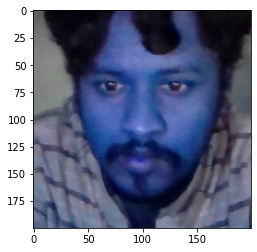

In [24]:
plt.imshow(plt.imread('Facial_images/Sayan/Sayan0.jpg'))
img_to_encoding('Facial_images/Sayan/Sayan0.jpg', model).shape

In [ ]:
def cutfaces(image, faces_coord):
  faces = []
  for (x,y,w,h) in faces_coord:
    w_rm = int(0.2 * w/2)
    faces.append(image[y:y+h, x+w_rm: x+w - w_rm])

  return faces

In [ ]:
faces = cutfaces(img, faces_coord)


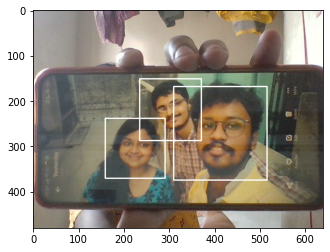

In [ ]:
PADDING = 25
frame = img
for (x,y,w,h) in faces_coord:
  x1 = x-PADDING
  y1 = y-PADDING
  x2 = x+w+PADDING
  y2 = y+h+PADDING
  img = cv2.rectangle(frame, (x1,y1),(x2,y2), (255,255,2555),2)
  height, width, channels = frame.shape
  cut_image = img[max(0, y1):min(height, y2), max(0, x1):min(width, x2)]

plt.imshow(img)

True

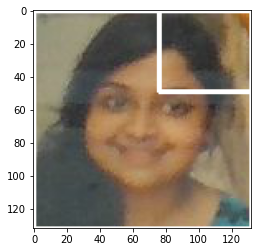

In [ ]:
plt.imshow(cut_image)
cv2.imwrite('Faces/temp.jpg', cut_image)

In [ ]:
database['sayan'] = img_to_encoding('Faces/temp.jpg', model)

In [ ]:
enc = database.items()
dist = np.linalg.norm()

AttributeError: ignored

In [ ]:
import dlib
from imutils import face_utils
from imutils.face_utils import FaceAligner

In [ ]:
detector = dlib.get_frontal_face_detector()

In [ ]:
shape_predictor = dlib.shape_predictor('')